In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
from scipy.special import softmax

from timeit import default_timer as timer
import random
import cv2

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr

from tf_keras_vis.utils.callbacks import Print
# tf.compat.v1.disable_eager_execution()

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
#import vis.visualization
from tf_keras_vis.activation_maximization import ActivationMaximization

from tensorflow.python.framework import ops

import json
import pickle
import os
import sys
sys.path.append("../python/")
from helpers import *
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [2]:
# Globals
NUM_CHANNELS = 1
RESOLUTION_LIST = [128] # 64, 128] #, 224, 384]
SCENARIO_LIST = ["PrPo_Im"] #, "Pr_Im", "Pr_PoIm", "Pr_Po_Im"]
NUM_EPOCHS = 20
SAVED_MODEL_DIR = '../../results/models/'
MODEL_PERFORMANCE_METRICS_DIR = '../../results/model-performance/'
FULL_MODEL_PATH = '../../results/models/opt-cnn-PrPo_Im-128-px/model'

In [3]:
## these can also be globally set.
trial_seed = 1
image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)

In [4]:
m = models.load_model(FULL_MODEL_PATH)

Why do we have two functions named "grad_cam"? If one is just an example from elsewhere, please comment it out.

In [8]:
# def grad_cam(input_model, image, cls, layer_name):
#     """GradCAM method for visualizing input saliency."""
#     y_c = input_model.output[0, cls]
#     conv_output = input_model.get_layer(layer_name).output
#     grads = K.gradients(y_c, conv_output)[0]
#     # Normalize if necessary
#     # grads = normalize(grads)
#     gradient_function = K.function([input_model.input], [conv_output, grads])

#     output, grads_val = gradient_function([image])
#     output, grads_val = output[0, :], grads_val[0, :, :, :]

#     weights = np.mean(grads_val, axis=(0, 1))
#     cam = np.dot(output, weights)

#     # Process CAM
#     cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
#     cam = np.maximum(cam, 0)
#     cam = cam / cam.max()
#     return cam

In the `grad_cam` function, update all variable names.

In [5]:
# Replaced all list identifies (i.e. cam_list) with variables indicating single image usage.
def grad_cam(index): 
    #     ALT: use train_test_split
    training_images,validation_images,training_labels,validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[128]["PrPo_Im"]]), 
                np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), stratify= np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), test_size=.2, random_state = trial_seed)
    
    #assert validation_labels[index].mean(axis=0)[0] == 0 ## This will throw an error for an image in the 1 class. Elaborate on it or comment out.
    cam_img = index # class activation map corresponds to the specified image index 
    class_labels = getClassLabels("PrPo_Im")
    print("Observed image class: ", class_labels[np.argmax(validation_labels[cam_img])])
    
    def loss(output):
        """Returns score corresponding to class of given image index"""                                       
        print("Loss output: ", output) ##
        loss_list = [output[i][j] for i, j in enumerate([np.argmax(j) for j in validation_labels[cam_img] ])]
        print(loss_list)
        print([softmax(loss) for loss in output.numpy()])
        return loss_list

    # Model_modifier function required for gradcam
    def model_modifier(model):
        """Remove softmax activation of last layer in model"""
        model.layers[-1].activation = tf.keras.activations.linear ## What does this do? put a note
        return model
    
    gradcam_image = validation_images[cam_img]
    gradcam = Gradcam(m, model_modifier = model_modifier)
    cam = gradcam(loss, gradcam_image, penultimate_layer = -1) ## What does `penultimate_layer` do? Check github to see if option is still active
    cam = normalize(cam)
    cam = np.squeeze(cam) # replace np.squeeze 
    print("Shape of heatmap matrix:", cam.shape )
    return cam, gradcam_image

In [21]:
def plotGradCam(index, c_map='gist_gray'):
    gradcam_dir = '../../figures/06162021/GradCam/'
    gcam = grad_cam([index])
    if not os.path.exists(gradcam_dir):
        os.makedirs(gradcam_dir)

    heatmap = np.uint8(cm.jet(gcam[0])[..., :3] * 255)
    plt.imshow(np.squeeze(gcam[1], axis=2), cmap='gist_gray') #remove axes of length one from gradcam_images
#             plt.set_title(str(cam_list[image_counter]))
    plt.imshow(heatmap, cmap='gist_gray', alpha=0.5) # overlay
    plt.tight_layout()
        
    plt.figure(figsize=(5, 5))
    plt.suptitle('Grad-CAM')
    plt.title('Index ' + str(index), y=-0.06)
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(np.squeeze(gcam[1]), cmap=c_map)
    plt.subplots_adjust(top=0.92)
    print(gcam[0])
    plt.savefig(gradcam_dir+"guided-gradcam-index-"+str(index)+'-'+c_map+".png")
    plt.show()

In [8]:
index = 180

<ipython-input-5-9dfeecf037fa>:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  print("Observed image class: ", class_labels[np.argmax(validation_labels[cam_img])])
<ipython-input-5-9dfeecf037fa>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  gradcam_image = validation_images[cam_img]
<ipython-input-5-9dfeecf037fa>:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which w

Observed image class:  Improbable
Loss output:  tf.Tensor([[-5.9293814  6.7700357]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=6.7700357>]
[array([3.0528959e-06, 9.9999714e-01], dtype=float32)]
Shape of heatmap matrix: (128, 128)
[[0.43412858 0.4355876  0.43973613 ... 0.37266687 0.36662602 0.36455438]
 [0.42981687 0.43125325 0.43534768 ... 0.3734849  0.36746478 0.36540198]
 [0.41831145 0.41968694 0.42363632 ... 0.37590316 0.36990443 0.3678525 ]
 ...
 [0.00522461 0.00791176 0.01542765 ... 0.07545757 0.06172598 0.05679033]
 [0.00692823 0.00969556 0.01742836 ... 0.06517486 0.05171213 0.04688491]
 [0.00762745 0.01042197 0.01822827 ... 0.06138461 0.04802742 0.04324253]]


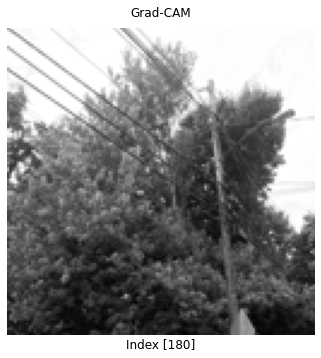

In [22]:
plotGradCam([index])

In [7]:
# Saving GCAM objects of validation images before disabling eager execution
gcam101 = grad_cam([101])
gcam18 = grad_cam([18])
gcam180 = grad_cam([180])
gcam212 = grad_cam([212])
gcam184 = grad_cam([184])

Observed image class:  Improbable
Loss output:  tf.Tensor([[-8.346948 10.684904]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=10.684904>]
[array([5.4271445e-09, 1.0000000e+00], dtype=float32)]
Shape of heatmap matrix: (128, 128)
Observed image class:  Improbable
Loss output:  tf.Tensor([[-9.487238 12.32506 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=12.32506>]
[array([3.3654213e-10, 1.0000000e+00], dtype=float32)]
Shape of heatmap matrix: (128, 128)
Observed image class:  Improbable
Loss output:  tf.Tensor([[-5.9293814  6.7700357]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=6.7700357>]
[array([3.0528959e-06, 9.9999714e-01], dtype=float32)]
Shape of heatmap matrix: (128, 128)
Observed image class:  Improbable
Loss output:  tf.Tensor([[-7.2653522  7.6167865]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=7.6167865>]
[array([3.4416686e-07, 9.9999952e-01], dtype=float32

In [8]:
# Save GCAM objects in a list to easily iterate over
gcam_list = [gcam101, gcam18, gcam180, gcam212, gcam184]

In [9]:
# Disable eager execution (GBP requirement)
# WARNING: kernel has to be restarted for GCAM to be called again.
# Replace Keras backed gradient with Gradient Tape for a permanent solution.
tf.compat.v1.disable_eager_execution()

def guided_backprop(index):#101
    #     ALT: use train_test_split
    training_images,validation_images,training_labels,validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[128]["PrPo_Im"]]), 
                np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), stratify= np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), test_size=.2, random_state = trial_seed)
    
    class_labels = getClassLabels("PrPo_Im")
    assert validation_labels[index].mean(axis=0)[0] == 0
    cam_list = index
    
    backprop_images = validation_images[cam_list]
    
    def register_gradient():
        if "GuidedBackProp" not in ops._gradient_registry._registry:
            @ops.RegisterGradient("GuidedBackProp")
            def _GuidedBackProp(op, grad):
                dtype = op.inputs[0].dtype
                return grad * tf.cast(grad > 0., dtype) * tf.cast(op.inputs[0] > 0., dtype)

    def modify_backprop(model, name, monochrome=True):
        g = tf.compat.v1.get_default_graph()
        with g.gradient_override_map({'Relu': name}):

            # get layers that have an activation
            layer_dict = [layer for layer in model.layers[1:]
                          if hasattr(layer, 'activation')]

            # replace relu activation
            for layer in layer_dict:
                if layer.activation == tf.keras.activations.relu:
                    layer.activation = tf.nn.relu

            # re-instanciate a new model
            new_model = models.load_model(FULL_MODEL_PATH)
            
        return new_model

    def guided_backpropagation(img_tensor, model, activation_layer):
        model_input = model.input
        layer_output = model.get_layer(activation_layer).output

        max_output = K.max(layer_output, axis=3)
        
        get_output = K.function([model_input], [K.gradients(max_output, model_input)[0]])
        print("Gradient length: ",len(K.gradients(max_output, model_input)))
        saliency = get_output([img_tensor])
        print(saliency[0])
        
        return saliency[0]
    
    register_gradient()
    guided_model = modify_backprop(m, 'GuidedBackProp')
    gradient = guided_backpropagation(backprop_images, guided_model, 'conv2d_4')
#     print()
    gradient_sq = np.squeeze(gradient[0], axis=2)
    print("Shape of heatmap matrix:", gradient_sq.shape)
    
    return gradient_sq, index

In [21]:
def guided_backprop_gt(index):#101
    ## Original implementation: https://gist.github.com/you359/d19449a1c64bb43519a11e5d9d430453
    training_images, validation_images, training_labels, validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[128]["PrPo_Im"]]), 
                np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), stratify= np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), test_size=.2, random_state = trial_seed)
    
    class_labels = getClassLabels("PrPo_Im")
    # assert validation_labels[index].mean(axis=0)[0] == 0 ## only makes sense for class 0 images; otherwise, assert validation_labels[index].mean(axis=0)[1]
    cam_list = index
    
    backprop_images = validation_images[cam_list]
    
    def register_gradient(): ## modifies gradient to mask negative activations and gradients (guided signal)
        if "GuidedBackProp" not in ops._gradient_registry._registry:
            @ops.RegisterGradient("GuidedBackProp")
            def _GuidedBackProp(op, grad):
                dtype = op.inputs[0].dtype
                return grad * tf.cast(grad > 0., dtype) * tf.cast(op.inputs[0] > 0., dtype) ## See Fig1c of Springenberg et al., 2015 (p. 8)

    def modify_backprop(model, name, monochrome=True): 
        g = tf.compat.v1.get_default_graph()
        with g.gradient_override_map({'Relu': name}): ## update activation of ReLu
            # get layers that have an activation
            layer_dict = [layer for layer in model.layers[1:] if hasattr(layer, 'activation')]
            # replace relu activation
            for layer in layer_dict:
                if layer.activation == tf.keras.activations.relu:
                    layer.activation = tf.nn.relu
            # re-instantiate a new model
            new_model = models.load_model(FULL_MODEL_PATH)            
        return new_model

    #normalize saliency
    def guided_backpropagation(input_image, model, activation_layer):
        model_input = model.input
        print(model_input.shape)
        layer_output = model.get_layer(activation_layer).output
        print("Layer output shape: ", layer_output.shape)
        max_output = K.max(layer_output, axis=3) ## gets activation in layer of interest with greatest outputs (this what guided backprop does)
            ## in gbp, we visualize the part of the image that gives the greatest activation, hence this operation.
        print(max_output.shape) ## You should have commented on what the shapes are.
        
#         get_output = K.function([model_input], [K.gradients(max_output, model_input)[0]])
        
        ## May not ever work: https://github.com/tensorflow/tensorflow/issues/46194#issuecomment-827036146
        with tf.GradientTape() as tape: # attempt at replacing keras backend gradients
            model_input = model.input
            layer_output = model.get_layer(activation_layer).output
            max_output = K.max(layer_output, axis=3)
            grads = tape.gradient(max_output, model_input)[0] # TypeError: 'NoneType' object is not subscriptable
            print(grads.shape)            
            #get_output = K.function([model_input], [grads])

        #intermediate_layer_model = models.Model(inputs = model_input, outputs = grads)
        #intermediate_output = intermediate_layer_model.predict(input_image)
        #print(intermediate_output.shape) 
        # saliency = normalize(saliency) ## may not be necessary; actually it isn't
        # saliency = get_output([input_image])
        saliency = grads
        return saliency #saliency[0]
    
    register_gradient()
    guided_model = modify_backprop(m, 'GuidedBackProp')
    gradient = guided_backpropagation(backprop_images, guided_model, 'conv2d_4')
    
    return gradient, index

In [22]:
guided_backprop_gt([101])

(None, 128, 128, 1)
Layer output shape:  (None, 16, 16, 256)
(None, 16, 16)


AttributeError: 'KerasTensor' object has no attribute '_id'

In [10]:
gbp101 = guided_backprop([101])
gbp18  = guided_backprop([18])
gbp180 = guided_backprop([180])
gbp212 = guided_backprop([212])
gbp184 = guided_backprop([184])

Gradient length:  1
[[[[ 0.00078276]
   [ 0.00158801]
   [ 0.00218869]
   ...
   [ 0.00227443]
   [ 0.00229405]
   [ 0.00293886]]

  [[-0.00129388]
   [ 0.00819799]
   [ 0.00800379]
   ...
   [ 0.01349041]
   [ 0.00719786]
   [ 0.00643284]]

  [[-0.00017844]
   [ 0.00557406]
   [ 0.00375208]
   ...
   [ 0.00781585]
   [-0.00068772]
   [ 0.00439347]]

  ...

  [[-0.00226742]
   [ 0.01518545]
   [ 0.0040855 ]
   ...
   [ 0.00394544]
   [-0.00021767]
   [ 0.00622715]]

  [[ 0.00151458]
   [ 0.00420545]
   [ 0.00502296]
   ...
   [ 0.00226174]
   [ 0.00298391]
   [ 0.00417192]]

  [[ 0.00319271]
   [ 0.00802812]
   [-0.00247717]
   ...
   [ 0.00798536]
   [ 0.01017314]
   [ 0.00966706]]]]
Shape of heatmap matrix: (128, 128)
Gradient length:  1
[[[[ 1.9495704e-04]
   [ 1.2906461e-03]
   [ 2.6972278e-03]
   ...
   [ 2.6815841e-03]
   [ 2.7351084e-03]
   [ 2.6019053e-03]]

  [[-1.9600692e-03]
   [ 1.0261318e-02]
   [ 6.6663250e-03]
   ...
   [ 3.5513903e-03]
   [ 7.5243460e-03]
   [ 7.2476631

In [26]:
gbp101 = guided_backprop([101])

Gradient length:  1
[[[[ 0.00078276]
   [ 0.00158801]
   [ 0.00218869]
   ...
   [ 0.00227443]
   [ 0.00229405]
   [ 0.00293886]]

  [[-0.00129388]
   [ 0.00819799]
   [ 0.00800379]
   ...
   [ 0.01349041]
   [ 0.00719786]
   [ 0.00643284]]

  [[-0.00017844]
   [ 0.00557406]
   [ 0.00375208]
   ...
   [ 0.00781585]
   [-0.00068772]
   [ 0.00439347]]

  ...

  [[-0.00226742]
   [ 0.01518545]
   [ 0.0040855 ]
   ...
   [ 0.00394544]
   [-0.00021767]
   [ 0.00622715]]

  [[ 0.00151458]
   [ 0.00420545]
   [ 0.00502296]
   ...
   [ 0.00226174]
   [ 0.00298391]
   [ 0.00417192]]

  [[ 0.00319271]
   [ 0.00802812]
   [-0.00247717]
   ...
   [ 0.00798536]
   [ 0.01017314]
   [ 0.00966706]]]]
Shape of heatmap matrix: (128, 128)


In [11]:
# Save GBP objects in a list to easily iterate over
gbp_list = [gbp101, gbp18, gbp180, gbp212, gbp184]

In [12]:
def guided_gradcam(gcam, gbp, index, c_map='gist_gray'):
    # element-wise multiplication in Python
    # https://stackoverflow.com/questions/40034993/how-to-get-element-wise-matrix-multiplication-hadamard-product-in-numpy
    ggcam = gcam[0] * gbp[0]
#     ggcam = np.squeeze(ggcam[0])
    print('Shape of GGCAM: ', ggcam.shape)
    
    guided_gradcam = '../../figures/plottingGuided-GradCam/'
    if not os.path.exists(guided_gradcam):
        os.makedirs(guided_gradcam)
            
    plt.figure(figsize=(5, 5))
    plt.title('Guided GradCAM')
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(ggcam, cmap=c_map)
    print(ggcam)
    plt.savefig(guided_gradcam+"guided-gradcam-index-"+str(index)+'-'+c_map+".png")
    plt.show()

(128, 128)
[[ 2.1273510e-04  4.4280596e-04  6.5266847e-04 ...  7.1462523e-04
   7.0655270e-04  8.9897256e-04]
 [-3.5340531e-04  2.2965665e-03  2.3957363e-03 ...  4.2719757e-03
   2.2349441e-03  1.9839553e-03]
 [-4.9440536e-05  1.5824323e-03  1.1354362e-03 ...  2.5293471e-03
  -2.1838064e-04  1.3860350e-03]
 ...
 [-3.4501660e-04  2.4055056e-03  7.1815058e-04 ...  7.0152147e-04
  -3.4968110e-05  9.6174475e-04]
 [ 2.2989961e-04  6.6426635e-04  8.7948510e-04 ...  3.6496783e-04
   4.2927510e-04  5.7377678e-04]
 [ 4.8442875e-04  1.2673235e-03 -4.3328328e-04 ...  1.2402084e-03
   1.4006083e-03  1.2692821e-03]]


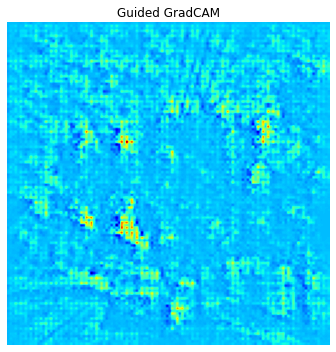

(128, 128)
[[ 4.3808872e-05  2.9572836e-04  6.5103493e-04 ...  6.3918246e-04
   6.2156573e-04  5.8105512e-04]
 [-4.4064358e-04  2.3525096e-03  1.6104919e-03 ...  8.5985428e-04
   1.7390025e-03  1.6468358e-03]
 [-3.1466811e-04  1.4743487e-03  1.0418731e-03 ...  6.3159538e-04
  -1.5584921e-04  1.3146693e-03]
 ...
 [-7.8418426e-04  5.7402113e-04 -9.1804191e-05 ...  1.4951953e-04
   7.5019634e-06  3.6284731e-05]
 [-8.2842576e-05  3.9724844e-05  3.4235549e-04 ...  1.0154709e-04
   3.1764062e-05  4.4762405e-06]
 [-1.8591131e-04  2.8909958e-06  1.4259198e-04 ...  1.6059876e-04
   1.9276715e-05  0.0000000e+00]]


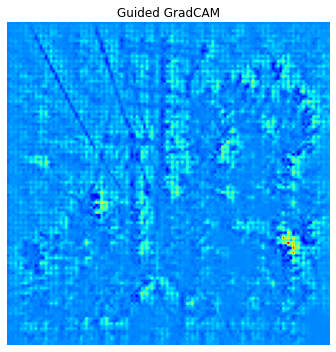

(128, 128)
[[-1.2026123e-04  4.2528592e-04  1.4797808e-03 ...  1.1277200e-03
   1.0350709e-03  8.7758404e-04]
 [-5.3936819e-04  1.2958602e-03  1.5710529e-03 ...  3.8543961e-03
   2.6685251e-03  2.9418513e-03]
 [ 6.4193236e-04  1.9322721e-03 -8.5128209e-04 ...  3.6560465e-03
  -1.2928108e-04  1.9506607e-03]
 ...
 [-7.4347503e-07  9.6844924e-05  3.8941835e-05 ...  1.1585836e-03
   1.0789932e-04  4.9017149e-04]
 [ 8.5586826e-06  2.8065864e-05  6.8172645e-05 ...  2.5155588e-05
   2.9090431e-04  2.1355700e-04]
 [ 2.4088702e-05  3.7929363e-05 -6.3494554e-05 ...  3.2835008e-04
   2.2122111e-04  1.4751373e-04]]


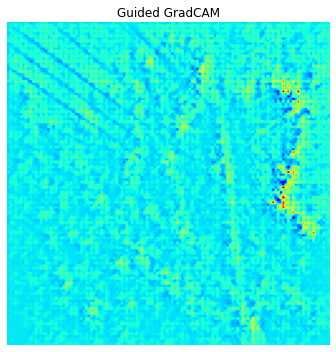

(128, 128)
[[-4.9581627e-06  2.2439440e-04  1.2875315e-03 ...  8.1711082e-04
   8.4440457e-04  8.1140985e-04]
 [-5.3164648e-04  3.0678173e-03  2.5424098e-03 ...  2.2523638e-03
   2.7962415e-03  2.7890427e-03]
 [-3.3672177e-04  2.2687714e-03  1.7648742e-03 ...  2.4510212e-03
  -1.7826853e-05  1.8585676e-03]
 ...
 [ 3.8734105e-04  2.1481770e-03 -6.1579625e-04 ...  2.8343706e-03
   1.0363851e-03  2.2170565e-03]
 [ 2.7576945e-04  3.2612472e-04  6.5125973e-04 ...  1.5737552e-03
   6.3857838e-04  9.8023622e-04]
 [ 3.0469606e-04  1.1074544e-03 -2.2863440e-04 ...  2.1302365e-03
   9.4543601e-04  1.1308007e-03]]


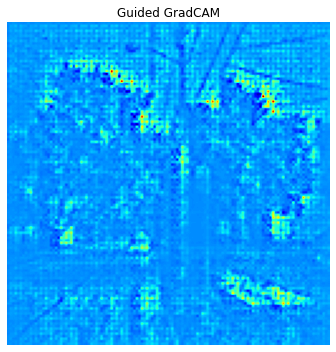

(128, 128)
[[-0.0000000e+00  8.3109148e-07  7.1965551e-06 ...  2.5456469e-04
   3.6120604e-04  1.3236365e-04]
 [-1.3865830e-06  2.1361349e-05  3.4351731e-05 ...  1.5948573e-03
   8.9605548e-04  9.4198697e-04]
 [-3.9021925e-06  3.6195885e-05  5.9071048e-05 ...  5.2657607e-04
  -5.6280807e-04  1.3689378e-03]
 ...
 [ 7.9866446e-04  9.7261666e-04 -2.2123252e-04 ...  2.5628051e-03
   6.2271510e-04  2.3708935e-03]
 [-1.1460628e-04  3.9947909e-04  5.7008531e-04 ...  2.3274261e-03
   9.7742712e-04  1.1536937e-03]
 [ 2.3681097e-04  3.1008429e-04 -9.1583344e-05 ...  3.1329603e-03
   2.0734065e-03  2.6089165e-03]]


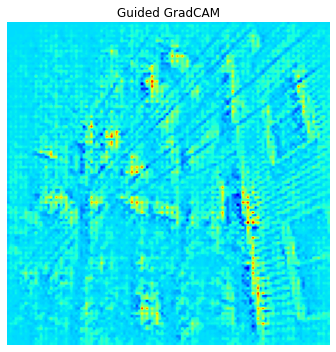

In [26]:
# Plot Guided-GCAM for 5 validation images
# Current implementation requires GCAM 
for i in range(len(gcam_list)):
    guided_gradcam(gcam_list[i], gbp_list[i], gbp_list[i][1], 'jet')

Shape of GGCAM:  (128, 128)
[[ 2.1273510e-04  4.4280596e-04  6.5266847e-04 ...  7.1462523e-04
   7.0655270e-04  8.9897256e-04]
 [-3.5340531e-04  2.2965665e-03  2.3957363e-03 ...  4.2719757e-03
   2.2349441e-03  1.9839553e-03]
 [-4.9440536e-05  1.5824323e-03  1.1354362e-03 ...  2.5293471e-03
  -2.1838064e-04  1.3860350e-03]
 ...
 [-3.4501660e-04  2.4055056e-03  7.1815058e-04 ...  7.0152147e-04
  -3.4968110e-05  9.6174475e-04]
 [ 2.2989961e-04  6.6426635e-04  8.7948510e-04 ...  3.6496783e-04
   4.2927510e-04  5.7377678e-04]
 [ 4.8442875e-04  1.2673235e-03 -4.3328328e-04 ...  1.2402084e-03
   1.4006083e-03  1.2692821e-03]]


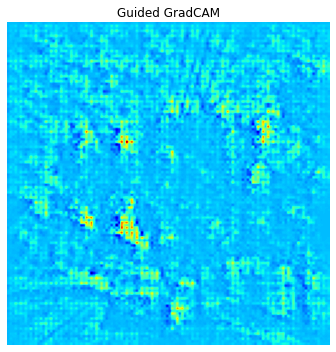

In [15]:
# Single Guided Gradcam Visualization
guided_gradcam(gcam101, gbp101, gbp101[1], 'jet')

In [17]:
# Plot backpropagation using keras backend gradient
def plotBackprop(gbp, c_map = 'gist_gray'):
    plt.figure(figsize=(5, 5))
    plt.title('GBP')
    plt.axis('off')
    plt.tight_layout()
#     norm_gbp = normalize(gbp[0]) # normalized gbp output
    plt.imshow(gbp[0], cmap=c_map)
    print(gbp[0].shape)
    plt.savefig('../../figures/plottingBackProp/guided-backprop-index-'+str(gbp[1])+'-'+c_map+'.png')
    plt.show()

(128, 128)


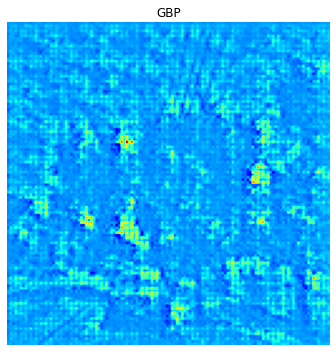

In [18]:
plotBackprop(gbp101, 'jet')

(128, 128)


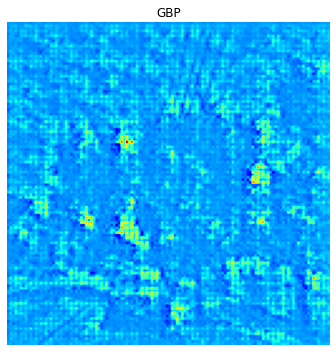

(128, 128)


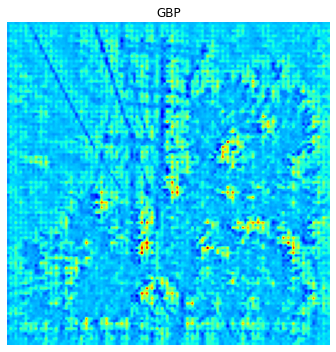

(128, 128)


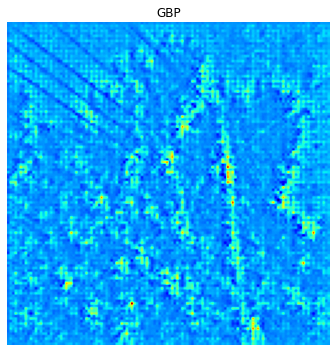

(128, 128)


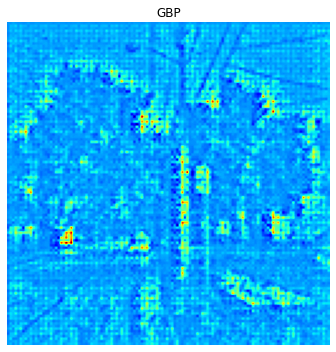

(128, 128)


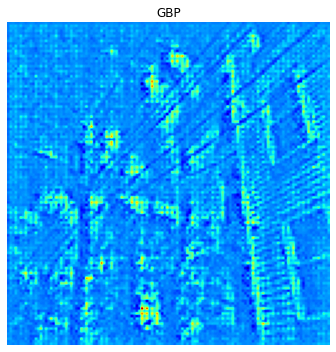

In [25]:
# Plot guided back propagation for all images in the GBP list
for i in range(len(gbp_list)):
    plotBackprop(gbp_list[i], gbp_list[i][1], 'jet')